In [1]:
import sys
from data_helper import *

import keras
from keras.optimizers import *
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

from matplotlib import pyplot as plt
from numpy import array
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0) # to make any matplotlib plot automatically a 20x10


import configparser
config = configparser.ConfigParser()
config.read('config/mylstmconfig.ini')

scaler = MinMaxScaler(feature_range=(0,1))
eco_tools_path = config['SETUP']['eco_tools_path']
sys.path.append(eco_tools_path)
from ecotools.pi_client import pi_client
pc = pi_client(root = 'readonly')

callbacks_list = [EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, verbose=2)]
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))


Using TensorFlow backend.


In [2]:
point_name = config['PI']['point_name']
start = config['PI']['start']
end = config['PI']['end']
interval = config['PI']['interval']
calculation = config['PI']['calculation']

In [3]:
point_list = [point_name, 'aiTIT4045']
df = pc.get_stream_by_point(point_list, start = start, end = end, calculation = calculation, interval= interval)
#df = pc.get_stream_by_point(point_list, end='*', calculation = calculation, interval= interval)
df = df.dropna(how='any')
df.head()

Grabbing WebIDs ...
WebID collection complete!
14:55:03: Sending API request... Chunk 1 of 1
14:55:05: Response recieved for 2 tags! (2.59)


/Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1027: FutureWarning: The errors argument is deprecated and will be removed in a future release. Use nonexistent='NaT' or nonexistent='raise' instead.
  "instead.", FutureWarning)


,GBSF_Electricity_Demand_kBtu,aiTIT4045
Timestamp,,
2016-01-01 00:00:00,2550.633333,40.409643
2016-01-01 01:00:00,2535.975618,40.079128
2016-01-01 02:00:00,2538.258333,40.090998
2016-01-01 03:00:00,2548.635795,40.114107
2016-01-01 04:00:00,2556.464644,39.902123


In [4]:
df, df1 = clean_train_data(df, eval_expression=["df.loc[df['GBSF_Electricity_Demand_kBtu'] > 2400]","df.loc[df.index.year >= 2019]"])
#print(df.shape)
#print(df1.shape)

Evaluating: df.loc[df['GBSF_Electricity_Demand_kBtu'] > 2400]
Evaluating: df.loc[df.index.year >= 2019]


In [5]:
df.shape

(30974, 2)

In [6]:
df1.shape

(4871, 2)

In [7]:
df = create_standard_multivariable_df(df)
df1 = create_standard_multivariable_df(df1)

Generated: 49 columns
Generated: 49 columns


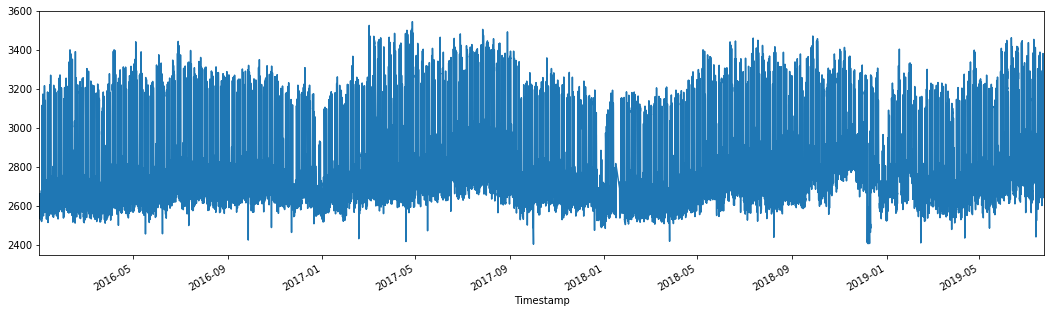

In [8]:
df[point_name].plot(figsize = (18,5))

```def add_rolling_mean(df, point_loc, rolling):
    return df.iloc[ : , point_loc].rolling(rolling).mean()```

```kwargs = {'point_loc': 0, 'rolling': '12h'}
df = add_variable_to_df(df, add_rolling_mean, col_name="Rolling12_mean", kwargs = kwargs)
df1 = add_variable_to_df(df1, add_rolling_mean, col_name="Rolling12_mean", kwargs = kwargs)```

In [9]:
print(f"df: {df.shape}")
print(f"df1: {df1.shape}")

df: (30973, 51)
df1: (4870, 51)


In [10]:
np.setdiff1d(df.columns,df1.columns)


array([], dtype=object)

In [11]:
def scale_keras(X, y):
    # normalize the dataset
    scaler_x = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler((0, 1))
    X = scaler_x.fit_transform(X)
    y = scaler_y.fit_transform(np.array(y).reshape((-1,1)))
    # split into train and test sets
    train_size = int(len(X) * 0.7)
    test_size = len(X) - train_size
    X_train, X_test = X[0:train_size], X[test_size:len(X)]
    y_train, y_test = y[0:train_size], y[test_size:len(y)]
    return X_train, X_test, y_train, y_test, scaler_x, scaler_y

In [12]:
y = df[point_name]
X = df.drop(columns=point_name)
y1 = df1[point_name]
X1 = df1.drop(columns=point_name)

In [13]:
X_train, X_test, y_train, y_test, scaler_x, scaler_y = scale_keras(X, y)
X1_train, X1_test, y1_train, y1_test, scaler_x1, scaler_y1 = scale_keras(X1, y1)

In [14]:
X_train.shape

(21681, 50)

In [15]:
y_train.shape

(21681, 1)

In [16]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

X1_train = np.reshape(X1_train, (X1_train.shape[0], 1, X1_train.shape[1]))
X1_test = np.reshape(X1_test, (X1_test.shape[0], 1, X1_test.shape[1]))

In [17]:
train = DataFrame()
val = DataFrame()
np.random.seed(42)
epochs = 100
neurons = 100
for i in range(1):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences = True))
    model.add(LSTM(neurons))
    model.add(Dense(1))
    model.compile(optimizer = Adam(lr = 0.001), loss = 'mean_squared_error')
    #X,y = get_train()
    #valX, valY = get_val()
    # fit model
    history = model.fit(X_train, y_train, epochs = epochs, validation_split = 0.3, shuffle = False)
    # story history
    train[str(i)] = history.history['loss']
    val[str(i)] = history.history['val_loss']

W0723 14:55:07.623157 4482135488 deprecation_wrapper.py:119] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0723 14:55:07.638419 4482135488 deprecation_wrapper.py:119] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 14:55:07.640373 4482135488 deprecation_wrapper.py:119] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0723 14:55:07.947999 4482135488 deprecation_wrapper.py:119] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimiz

Train on 15176 samples, validate on 6505 samples
Epoch 1/100
15176/15176 [==============================] - 3s 217us/step - loss: 0.0079 - val_loss: 0.0022
Epoch 2/100
15176/15176 [==============================] - 2s 134us/step - loss: 0.0017 - val_loss: 0.0029
Epoch 3/100
15176/15176 [==============================] - 2s 138us/step - loss: 0.0017 - val_loss: 0.0024
Epoch 4/100
15176/15176 [==============================] - 2s 134us/step - loss: 0.0016 - val_loss: 0.0024
Epoch 5/100
15176/15176 [==============================] - 2s 135us/step - loss: 0.0014 - val_loss: 0.0022
Epoch 6/100
15176/15176 [==============================] - 2s 133us/step - loss: 0.0012 - val_loss: 0.0022
Epoch 7/100
15176/15176 [==============================] - 2s 134us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 8/100
15176/15176 [==============================] - 2s 133us/step - loss: 0.0011 - val_loss: 0.0029
Epoch 9/100
15176/15176 [==============================] - 2s 135us/step - loss: 0.0011 - val_l

15176/15176 [==============================] - 2s 150us/step - loss: 7.1507e-04 - val_loss: 0.0016
Epoch 75/100
15176/15176 [==============================] - 2s 144us/step - loss: 7.1351e-04 - val_loss: 0.0017
Epoch 76/100
15176/15176 [==============================] - 2s 145us/step - loss: 7.1051e-04 - val_loss: 0.0017
Epoch 77/100
15176/15176 [==============================] - 2s 140us/step - loss: 7.0605e-04 - val_loss: 0.0017
Epoch 78/100
15176/15176 [==============================] - 2s 140us/step - loss: 6.9946e-04 - val_loss: 0.0017
Epoch 79/100
15176/15176 [==============================] - 2s 139us/step - loss: 6.9234e-04 - val_loss: 0.0017
Epoch 80/100
15176/15176 [==============================] - 2s 141us/step - loss: 6.8538e-04 - val_loss: 0.0017
Epoch 81/100
15176/15176 [==============================] - 2s 142us/step - loss: 6.7849e-04 - val_loss: 0.0016
Epoch 82/100
15176/15176 [==============================] - 2s 141us/step - loss: 6.7253e-04 - val_loss: 0.0016
Epoch

[ 1  7 39 76 86]


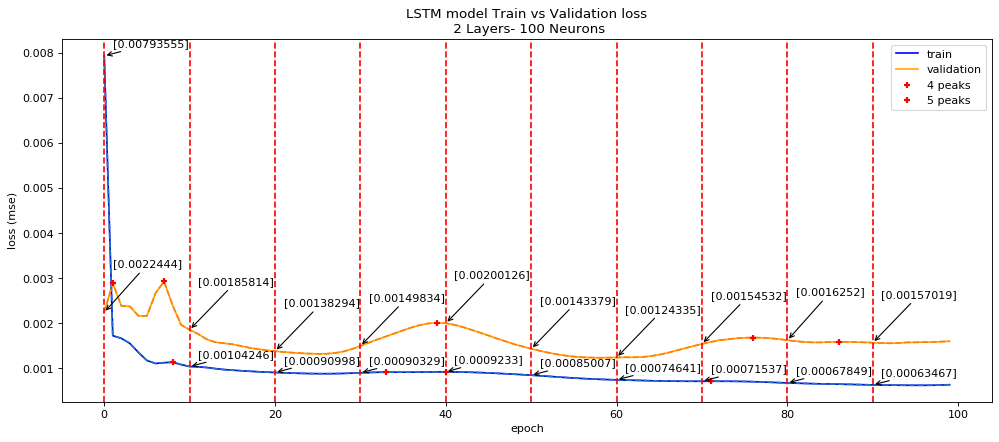

In [28]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
show_every = 10

vertical_lines = [x for x in range(epochs) if x % show_every == 0]

plt.plot(train, color='blue', label='train')
plt.plot(val, color='orange', label='validation')
plt.title(f'LSTM model Train vs Validation loss\n 2 Layers- {neurons} Neurons')
plt.ylabel('loss (mse)')
plt.xlabel('epoch')
plt.legend()

unflat = train.values.tolist()
unflat1 = val.values.tolist()
flatten = [ item for sublist in  unflat for item in sublist]
flatten1 = [ item for sublist in  unflat1 for item in sublist]
import peakutils
from peakutils.plot import plot as pplot

indexes = peakutils.indexes(flatten, thres=0.005, min_dist=1)
indexes1 = peakutils.indexes(flatten1, thres=0.2, min_dist=1)

pplot(train.index, train.values, indexes)
pplot(val.index, val.values, indexes1)
for xc in vertical_lines:
    plt.axvline(x=xc, color = 'r', linestyle = '--')
for i,j in zip(train.index, train.values):
    if i % show_every == 0:
        plt.annotate(str(j), xy = (i,j ), xytext=(i+1, j+.000200),arrowprops=dict(arrowstyle="->",connectionstyle="arc3"))
for i,j in zip(val.index, val.values):
    if i % show_every == 0:
        plt.annotate(str(j), xy = (i,j ), xytext=(i+1, j+.0010),arrowprops=dict(arrowstyle="->",connectionstyle="arc3"))
#plt.savefig('new_300_epochs.png')
print(indexes1)
plt.show()

R2 of train = 0.965
R2 of test = 0.496

RMSE of train = 44.385
RMSE of test = 89.052

MAE of train = -27.28
MAE of test = 48.293


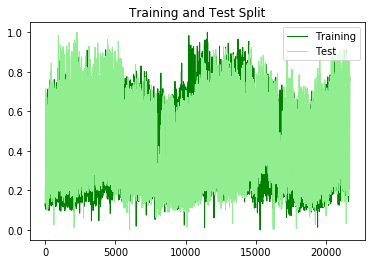

<Figure size 1296x144 with 0 Axes>

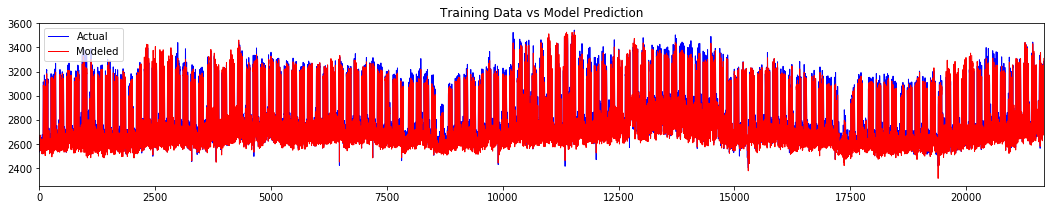

<Figure size 1296x144 with 0 Axes>

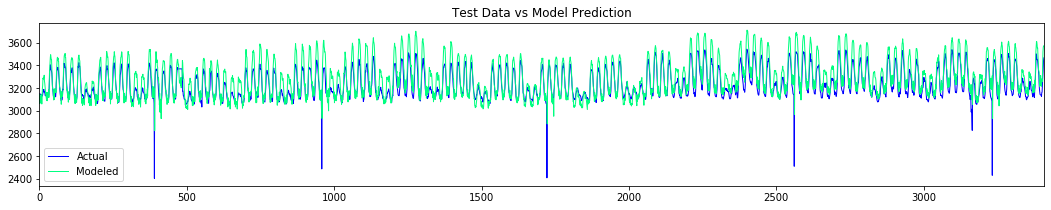

In [19]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import math
plt.plot(y_train, linewidth=1, color='green')
plt.plot(y_test, color='lightgreen', linewidth=1)
plt.title("Training and Test Split")
plt.legend(['Training','Test'])

pred_train = history.model.predict(X_train)
pred_train_inv = scaler_y.inverse_transform(pred_train.reshape(-1,1))
pred_test = history.model.predict(X1_test)
pred_test_inv = scaler_y.inverse_transform(pred_test.reshape(-1,1))
pred_test_inv = pred_test_inv+200
plt.figure(figsize=(18,2))
training_comparison = pd.DataFrame({"Actual":scaler_y.inverse_transform(y_train).reshape((-1,)),
                                   "Modeled":pred_train_inv.reshape((-1,))}, index=range(len(y_train)))
training_comparison.sort_index().plot(figsize=(18,3),
                         title="Training Data vs Model Prediction",
                         linewidth=1,
                         color=['blue','red'])
 
plt.figure(figsize=(18,2))
test_comparison = pd.DataFrame({"Actual":scaler_y.inverse_transform(y1_test).reshape((-1,)),
                                   "Modeled":pred_test_inv.reshape((-1,))}, index=range(len(y1_test)))
test_comparison.sort_index().plot(figsize=(18,3),
                     title="Test Data vs Model Prediction",
                     linewidth=1,
                     colormap='winter')

r2_train = r2_score(scaler_y.inverse_transform(y_train).reshape((-1,)), pred_train_inv.reshape(-1,1))
print(f"R2 of train = {round(r2_train,3)}")
r2_test = r2_score(scaler_y.inverse_transform(y1_test).reshape((-1,)), pred_test_inv.reshape(-1,1))
print(f"R2 of test = {round(r2_test,3)}")
print()
rmse_train = math.sqrt(mean_squared_error(scaler_y.inverse_transform(y_train).reshape((-1,)), pred_train_inv.reshape(-1,1)))
print(f"RMSE of train = {round(rmse_train,3)}")
rmse_test = math.sqrt(mean_squared_error(scaler_y.inverse_transform(y1_test).reshape((-1,)), pred_test_inv.reshape(-1,1)))
print(f"RMSE of test = {round(rmse_test,3)}")
print()
mae_train = np.median((pred_train_inv.reshape(-1,1) - scaler_y.inverse_transform(y_train).reshape((-1,))))
print(f"MAE of train = {round(mae_train,3)}")
mae_test = np.median((pred_test_inv.reshape(-1,1) - scaler_y.inverse_transform(y1_test).reshape((-1,))))
print(f"MAE of test = {round(mae_test,3)}")